# Machine Learning

## Set up

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# load data
df = pd.read_pickle("sample")
# show numerical values
df.describe()

,backers_count,goal,pledged,life,duration,prep
count,231381.000000,2.313810e+05,2.313810e+05,231381,231381,231381
mean,134.295772,4.729175e+04,1.227821e+04,33 days 20:09:57.300962,31 days 10:05:47.950847,42 days 21:29:37.516438
std,1095.131066,1.172776e+06,1.320999e+05,12 days 13:00:42.671194,14 days 07:00:24.493691,110 days 13:02:43.664584
min,0.000000,1.000000e-02,0.000000e+00,1 days 00:00:00,0 days 00:00:00,0 days 00:01:41
25%,2.000000,2.000000e+03,5.000000e+01,30 days 00:00:00,28 days 13:07:40,2 days 17:09:51
50%,19.000000,5.000000e+03,1.035000e+03,30 days 00:00:00,30 days 00:00:01,10 days 01:52:47
75%,74.000000,1.500000e+04,5.405420e+03,35 days 22:27:34,34 days 18:48:37,34 days 10:33:15
max,219382.000000,1.000000e+08,2.902191e+07,91 days 23:00:00,354 days 19:06:23,2313 days 16:40:37


In [3]:
# convert duration data to seconds
df['life_days'] = df['life'].dt.days
df['prep_days'] = df['prep'].dt.days
df['top100'] = df['top100'].fillna(99).astype(int)

In [30]:
# keep only successful / fail projects
# keep only US projects
data = df[(df.location_country =="US") & ((df.state == "successful")|(df.state == "failed"))].reset_index(drop = True)

# keep only numerical/categorical variables
DropCol = ['location_country','location_state','location_localized_name','location_name','cbsa','cbsa_name','creator_name',
      'category_name','launched_at','deadline','state_changed_at','life','duration','prep','pledged','backers_count']

data = data.drop(DropCol,axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159925 entries, 0 to 159924
Data columns (total 9 columns):
top100            159925 non-null int64
goal              159925 non-null float64
gender            159925 non-null object
category_broad    159925 non-null category
state             159925 non-null category
slug              159925 non-null object
blurb             159922 non-null object
life_days         159925 non-null int64
prep_days         159925 non-null int64
dtypes: category(2), float64(1), int64(3), object(3)
memory usage: 8.8+ MB


## Text Analysis 
### Structure analysis of headline
Reference: http://nbviewer.jupyter.org/github/AYLIEN/headline_analysis/blob/06f1223012d285412a650c201a19a1c95859dca1/main-chunks.ipynb#A-primer-on-parse-trees

### Sentiment analysis

In [5]:
print(data.slug.sample(5))
print(data.blurb.sample(5))

78605                              the-bachata-project-fund
145356               the-colossus-of-destiny-a-melvins-tale
62593                 dungeon-ravenstein-by-darkraven-games
131528    ravean-wallet-worlds-most-functional-minimalis...
50792     happy-animal-productions-mini-farm-organic-health
Name: slug, dtype: object
137795    The "Optical" series is my serving of everythi...
156320    REDEEM is the sequel to FALL, an urban fantasy...
105732    this is a documentary about the aftermath and ...
51153     Re-Inventing the Tequila industry, Providing h...
52538     How about a home cooked meal instead of a burger?
Name: blurb, dtype: object


In [6]:
from textblob import TextBlob

def sentiment_calc(text):
    try:
        return TextBlob(text).sentiment
    except:
        return None

# test
sentiment_calc(data['blurb'][0])

Sentiment(polarity=0.11666666666666665, subjectivity=0.37777777777777777)

In [7]:
data['slug'] = data['slug'].str.replace('-',' ')
data.slug.sample(5)

44006     blocks for tots making wood blocks sets from s...
141496                                           red folder
119431           eggchtropolis help us serve you for bm2010
2331                                    frye family band ep
131124    cook strain eat and store your food all in one...
Name: slug, dtype: object

In [8]:
data['slug_senti'] =  data['slug'].apply(sentiment_calc)
data[['slug_plor','slug_subj']] = data['slug_senti'].apply(pd.Series)

data['blurb_senti'] =  data['blurb'].apply(sentiment_calc)
data[['blurb_plor','blurb_subj']] = data['blurb_senti'].apply(pd.Series)

In [17]:
data[['blurb_plor','blurb_subj']] = data[['blurb_plor','blurb_subj']].fillna(value=0)
data.sample(5)

,cbsa,top100,goal,gender,category_broad,state,slug,blurb,life_days,prep_days,slug_senti,slug_plor,slug_subj,blurb_senti,blurb_plor,blurb_subj
21653,37980,1,4000.0,female,theater,successful,austentatious soundtrack,"The creators of fan-favorite, hilarious musica...",30,33,"(0.0, 0.0)",0.000000,0.000000,"(0.25, 0.5)",0.25,0.50
79160,19340,0,10000.0,unknown,music,successful,3 years hollow is going on their first ever tour,A regional band reaching to their fans. Reachi...,30,26,"(0.075, 0.19166666666666665)",0.075000,0.191667,"(0.0, 0.0)",0.00,0.00
158651,39300,1,18000.0,male,design,successful,kuma a reusable spork for modern life,Kuma™ is a compact spork that fits in your poc...,40,44,"(0.2, 0.3)",0.200000,0.300000,"(0.30000000000000004, 0.35)",0.30,0.35
88428,28300,0,1200.0,female,film & video,successful,deep end 0,Deep End is a student made film that encompass...,30,24,"(0.0, 0.4)",0.000000,0.400000,"(0.0, 0.30000000000000004)",0.00,0.30
151196,40060,1,80000.0,male,publishing,failed,bioremediation field manual clean up oil conta...,Bioremediation involves creating environments ...,30,3,"(0.3666666666666667, 0.7000000000000001)",0.366667,0.700000,"(0.0, 0.0)",0.00,0.00


## Remove Outliers

In [62]:
CatCol = ['gender','top100','category_broad']
NumCol = ['goal','life_days','prep_days','slug_plor','slug_subj','blurb_plor','blurb_subj']

data.describe()

,top100,goal,life_days,prep_days
count,159925.000000,1.599250e+05,159925.000000,159925.000000
mean,2.729504,3.806577e+04,33.441301,44.274504
std,13.587452,1.023592e+06,12.559958,115.370794
min,0.000000,1.000000e-02,1.000000,0.000000
25%,1.000000,2.000000e+03,30.000000,2.000000
50%,1.000000,5.000000e+03,30.000000,10.000000
75%,1.000000,1.300000e+04,35.000000,35.000000
max,99.000000,1.000000e+08,91.000000,2313.000000


In [19]:
import collections
c = collections.Counter()

for feature in NumCol:
    
    Q1 = np.percentile(data[feature], 25)
    Q3 = np.percentile(data[feature], 75)
    
    step = 1.5 * (Q3 - Q1)
    
    outlier = data[(~(data[feature] >= Q1 - step) & (data[feature] <= Q3 + step))]
    
    c.update(outlier.index)

In [20]:
# remove projects that have at least 2 outlier features
outliers = []

for ind,num in c.items(): 
    if num >= 2:
        outliers.append(ind)
        
len(outliers)/len(data)

0.014175394716273253

In [21]:
good_data = data.drop(data.index[outliers]).reset_index(drop = True)

In [22]:
good_data.describe()

,top100,goal,life_days,prep_days,slug_plor,slug_subj,blurb_plor,blurb_subj
count,157658.000000,1.576580e+05,157658.000000,157658.000000,157658.000000,157658.000000,157658.000000,157658.000000
mean,2.726490,3.849370e+04,33.636961,44.430793,0.048856,0.165422,0.150644,0.397319
std,13.577167,1.030911e+06,12.487155,115.610808,0.188267,0.273682,0.252876,0.285793
min,0.000000,1.000000e-02,1.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000
25%,1.000000,2.000000e+03,30.000000,2.000000,0.000000,0.000000,0.000000,0.155556
50%,1.000000,5.000000e+03,30.000000,10.000000,0.000000,0.000000,0.100000,0.400000
75%,1.000000,1.300000e+04,35.000000,35.000000,0.000000,0.333333,0.300000,0.591667
max,99.000000,1.000000e+08,91.000000,2313.000000,1.000000,1.000000,1.000000,1.000000


## Scaling and normalization

In [23]:
# split into features and target
target = good_data['state'].apply(lambda x: 1 if x == "successful" else 0)
feature = good_data.drop(['state','slug','blurb','slug_senti','blurb_senti'], axis = 1)

print(feature.head())
print(target.head())

    cbsa  top100    goal   gender category_broad  life_days  prep_days  \
0  31080       1  1000.0     male     publishing         30          6   
1  31080       1  1100.0  unknown     publishing         33          1   
2  31080       1   900.0     male     publishing         30        160   
3  31080       1  7900.0  unknown     publishing         31          3   
4  31080       1  7968.0  unknown     publishing         29        336   

   slug_plor  slug_subj  blurb_plor  blurb_subj  
0        0.0      0.000    0.116667    0.377778  
1        0.0      0.000    0.000000    1.000000  
2        0.0      0.000    0.233333    0.508333  
3        0.0      0.125   -0.100000    0.500000  
4        0.0      0.125    0.000000    0.000000  
0    1
1    1
2    1
3    0
4    0
Name: state, dtype: int64


In [24]:
# log data
feature[NumCol] = np.log(feature[NumCol]+1.00001)

In [25]:
# MinMax Scale
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
feature[NumCol] = scaler.fit_transform(feature[NumCol])


In [27]:
# pd.plotting.scatter_matrix(feature, alpha = 0.3, figsize = (14,8), diagonal = 'kde');
# feature.corr()

## One-hot-encoding categorical variables

In [116]:
feature_final = pd.get_dummies(feature, columns = CatCol)
# feature_final = feature.drop(CatCol, axis = 1)
feature_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157658 entries, 0 to 157657
Data columns (total 18 columns):
cbsa                    155192 non-null object
goal                    157658 non-null float64
category_broad          157658 non-null category
life_days               157658 non-null float64
prep_days               157658 non-null float64
slug_plor               157658 non-null float64
slug_subj               157658 non-null float64
blurb_plor              157658 non-null float64
blurb_subj              157658 non-null float64
gender_andy             157658 non-null uint8
gender_female           157658 non-null uint8
gender_male             157658 non-null uint8
gender_mostly_female    157658 non-null uint8
gender_mostly_male      157658 non-null uint8
gender_unknown          157658 non-null uint8
top100_0                157658 non-null uint8
top100_1                157658 non-null uint8
top100_99               157658 non-null uint8
dtypes: category(1), float64(7), object(1),

## Pipeline

In [117]:
# split train-test
from sklearn.model_selection import train_test_split

feature_final = feature_final.drop(['cbsa'],axis = 1)
feature_final = feature_final.drop(['category_broad'],axis = 1)


X_train, X_test, y_train, y_test = train_test_split(feature_final,
                                                   target, 
                                                   test_size = 0.2,
                                                   random_state = 23)
print(X_train.shape)
print(X_test.shape)

(126126, 16)
(31532, 16)


In [90]:
from sklearn.metrics import fbeta_score, accuracy_score
from time import time

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test):
    results = {}
    
    # training
    start = time()
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time()
    
    results['train_time'] = end - start
    
    # prediction
    
    start = time()
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time()
    
    results['pred_time'] = end - start
    
    results['acc_train'] = accuracy_score(y_train[:300],predictions_train)
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    results['f_train'] = fbeta_score(y_train[:300], predictions_train,0.5)
    results['f_test'] = fbeta_score(y_test, predictions_test, 0.5)
    
    print("{} trained on {} samples. ".format(learner.__class__.__name__, sample_size))

    return results

In [91]:
# naive score
precision = accuracy = np.sum(target)/len(target)

recall = 1
fscore = (1+0.25)*precision*recall/(0.25*precision+recall)

print("Naive Predictor: accuracy: {:.4f}, F:{:.4f}".format(accuracy, fscore))

Naive Predictor: accuracy: 0.5259, F:0.5810


### Training!

In [92]:
# from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


import visuals as vs

# clf_S = SVC(random_state = 2)
clf_Logit = LogisticRegression(random_state = 25)
clf_RF = RandomForestClassifier(random_state = 23)
clf_LDA = LinearDiscriminantAnalysis(n_components = 5)

samples_100 = len(y_train)
samples_10 = int(0.1*samples_100)
samples_1 = int(0.01*samples_100)

results = {}
for clf in [clf_Logit, clf_RF, clf_LDA]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1,samples_10, samples_100]):
        results[clf_name][i] = train_predict(clf, samples, X_train, y_train, X_test, y_test)


LogisticRegression trained on 1261 samples. 
LogisticRegression trained on 12612 samples. 
LogisticRegression trained on 126126 samples. 
RandomForestClassifier trained on 1261 samples. 
RandomForestClassifier trained on 12612 samples. 
RandomForestClassifier trained on 126126 samples. 
LinearDiscriminantAnalysis trained on 1261 samples. 
LinearDiscriminantAnalysis trained on 12612 samples. 
LinearDiscriminantAnalysis trained on 126126 samples. 


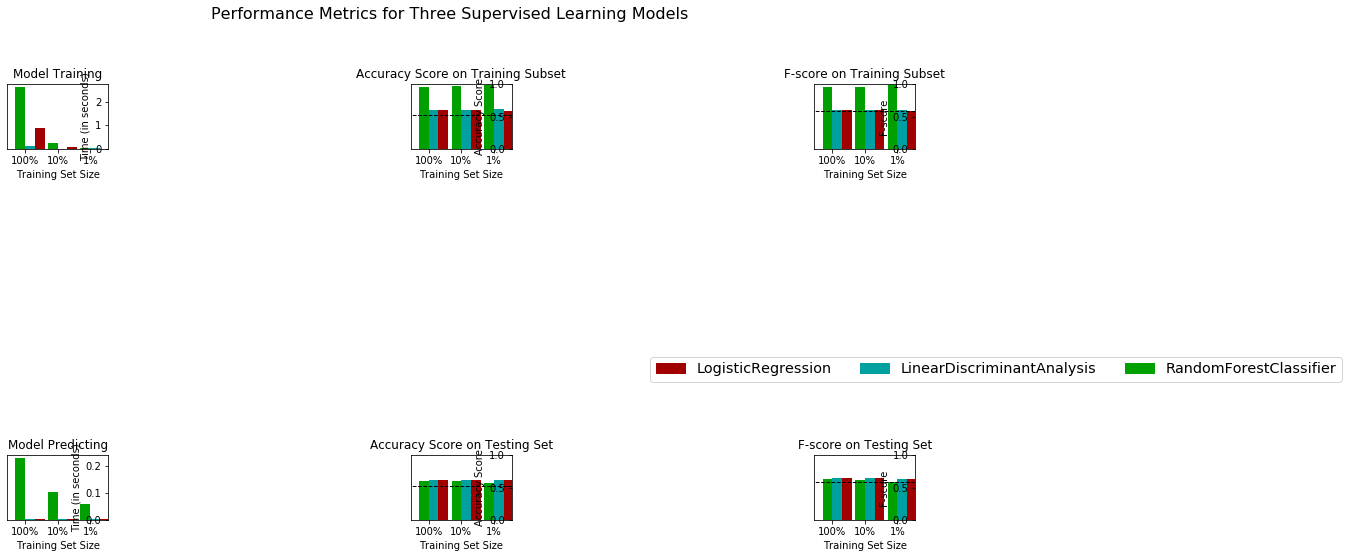

In [93]:
vs.evaluate(results, accuracy, fscore)
# results

### Tuning

In [96]:
# LDA Regression
from sklearn.model_selection  import GridSearchCV
from sklearn.metrics import make_scorer

clf = LinearDiscriminantAnalysis()

parameters = {'n_components':[2,5,10,15,20,25],
             'solver':['svd','lsqr','eigen']}

scorer = make_scorer(fbeta_score, beta = 0.5)
grid_obj = GridSearchCV(clf, parameters, scorer)

grid_fit = grid_obj.fit(X_train, y_train)

best_clf = grid_fit.best_estimator_

predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

print("untuned accuracy:{:.4f}".format(accuracy_score(y_test, predictions)))
print("optimized accuracy:{:.4f}".format(accuracy_score(y_test, best_predictions)))

print("untuned accuracy:{:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("optimized accuracy:{:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))


untuned accuracy:0.6247
optimized accuracy:0.6247
untuned accuracy:0.6426
optimized accuracy:0.6426


In [139]:
# Logistic Regression
from sklearn.model_selection  import GridSearchCV
from sklearn.metrics import make_scorer


clf = LogisticRegression(random_state=5)

parameters = {'C':[1,10,100,1000,100000,1000000],
             'tol':[0.0001,0.001,0.01,0.1]}

scorer = make_scorer(fbeta_score, beta = 0.5)
grid_obj = GridSearchCV(clf, parameters, scorer)

grid_fit = grid_obj.fit(X_train, y_train)

best_clf = grid_fit.best_estimator_

predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

print("untuned accuracy:{:.4f}".format(accuracy_score(y_test, predictions)))
print("optimized accuracy:{:.4f}".format(accuracy_score(y_test, best_predictions)))

print("untuned accuracy:{:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("optimized accuracy:{:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))


untuned accuracy:0.6329
optimized accuracy:0.6328
untuned accuracy:0.6498
optimized accuracy:0.6498


In [265]:
importances = best_clf.coef_

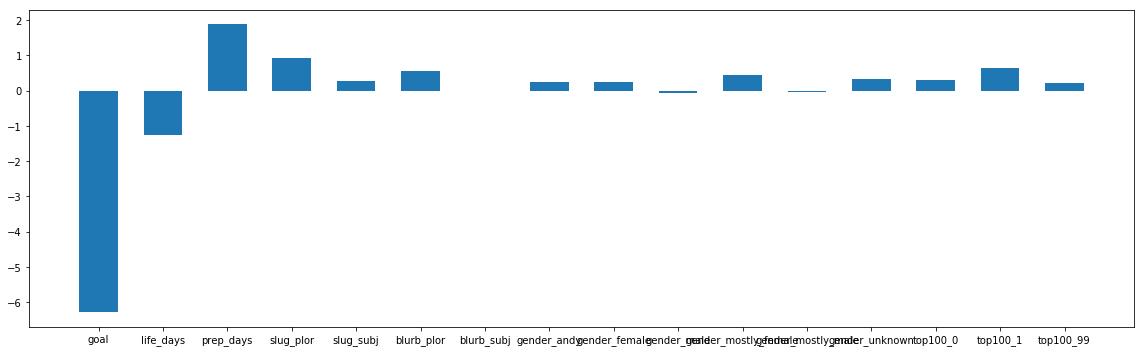

In [267]:
columns = X_train.columns.values
values = importances[0]

fig = plt.figure(figsize = (16,5))
plt.bar(np.arange(16), values, width = 0.6, align="center")
plt.xticks(np.arange(16), columns)
plt.tight_layout()
plt.show()  

## Feature Importance

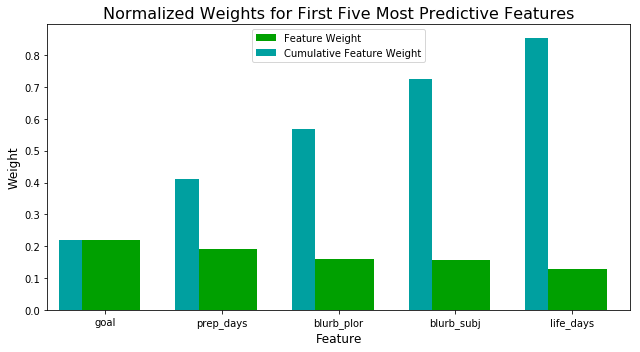

In [222]:
model = RandomForestClassifier(random_state = 40).fit(X_train, y_train)
importances = model.feature_importances_

vs.feature_plot(importances, X_train, y_train)
# importances

In [83]:
importances

array([ 0.22036194,  0.12805452,  0.19036846,  0.04632061,  0.05114044,
        0.15891518,  0.15627844,  0.00219488,  0.00732208,  0.00823947,
        0.0049243 ,  0.00475223,  0.0084347 ,  0.00478947,  0.00535252,
        0.00255078])

In [ ]:
# TODO
# CNN?
# categories?


## CNN

In [118]:
import keras

# Separate data and one-hot encode the output
# Note: We're also turning the data into numpy arrays, in order to train the model in Keras
features = np.array(X_train)
targets = np.array(pd.get_dummies(y_train))
features_test = np.array(X_test)
targets_test = np.array(pd.get_dummies(y_test))

print(features[:10])
print(targets[:10])

[[ 0.54950108  0.71587766  0.          0.93163285  0.51326042  0.93474698
   0.52788863  0.          0.          1.          0.          0.          0.
   1.          0.          0.        ]
 [ 0.71221575  0.71587766  0.30953556  0.96149454  0.41503689  0.95286281
   0.16992462  0.          0.          0.          0.          1.          0.
   0.          1.          0.        ]
 [ 0.46209125  0.76905557  0.          0.94321336  0.          0.96626827
   0.70781876  0.          1.          0.          0.          0.          0.
   0.          1.          0.        ]
 [ 0.40351551  0.71587766  0.33110002  0.94321336  0.          0.96678191
   0.64769771  0.          0.          0.          0.          0.          1.
   0.          1.          0.        ]
 [ 0.46209125  0.89267337  0.08947554  0.94321336  0.          0.94321336
   0.          0.          0.          0.          0.          0.          1.
   0.          1.          0.        ]
 [ 0.49973493  0.89267337  0.29723228  0.9432

In [136]:
# Imports

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD
from keras.utils import np_utils

# Building the model
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(16,)))
model.add(Dropout(.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(.1))
model.add(Dense(2, activation='sigmoid'))

# Compiling the model
model.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 128)               2176      
_________________________________________________________________
dropout_25 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_38 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_26 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_39 (Dense)             (None, 2)                 130       
Total params: 10,562
Trainable params: 10,562
Non-trainable params: 0
_________________________________________________________________


In [134]:
# Training the model
model.fit(features, targets, epochs=100, batch_size=500, verbose=0)

In [135]:
# Evaluating the model on the training and testing set
score = model.evaluate(features, targets)
print("\n Training Accuracy:", score[1])
score = model.evaluate(features_test, targets_test)
print("\n Testing Accuracy:", score[1])

126126/126126 [==============================] - 12s 91us/step

 Training Accuracy: 0.643095000238
31532/31532 [==============================] - 3s 84us/step

 Testing Accuracy: 0.646327540284


## SANDBOX

In [3]:
# SpaCy for structure analysis
import spacy 
from spacy import displacy
import difflib

EN = spacy.load("en")
nlp = spacy.load('en_core_web_sm')

In [35]:
# test tokens
data.slug.sample(5)

699                                        hotel-chicamauga
72401                          hearts-and-daggers-new-album
153857    help-kickstart-welcome-to-limericks-debut-ep-a...
149150    got-emissions-275-inch-x-9-inch-vinyl-bumper-s...
76986                                     the-warped-vinyls
Name: slug, dtype: object

In [39]:
slugs = [slug for slug in data['slug']]
slugs[1]

'chasing-gold-lined-storms'

In [90]:
def tokenize_text(docs, logging=False):
    texts = []
    counter = 1
    for doc in docs:
        if counter % 1000 == 0 and logging:
            print("Processed %d out of %d slugs." % (counter, len(docs)))
        counter += 1
        doc = nlp(doc, disable=['parser', 'ner'])
        tokens = [tok.pos_ for tok in doc]
        tokens = ' '.join(tokens)
        texts.append(tokens)
    return pd.Series(texts)

In [96]:
# tokenize all slugs.

slugs_tokenize = tokenize_text(slugs, True)

In [40]:
# slugs_tokenize.to_pickle("slugs_tokenize")
slugs_tokenize = pd.read_pickle("slugs_tokenize")
slugs_tokenize[1]


'VERB PUNCT NOUN PUNCT VERB PUNCT NOUN'

In [4]:
# difference in length and structure sequence
difflib.SequenceMatcher(None,slugs_tokenize[10],slugs_tokenize[2]).ratio()


0.6216216216216216

### Select a random sample randomly to train the classifier
Pair-wise similarity matrix for the headlines

In [23]:
# 1000 training set
np.random.seed(10)
sample_size = 1000
sample_index = np.random.randint(0, len(slugs_tokenize), sample_size)
m = np.zeros((sample_size,sample_size))

for i, slug_x in enumerate(slugs_tokenize[sample_index]):
    for j, slug_y in enumerate(slug_x):
        m[i][j] = difflib.SequenceMatcher(None,slug_x,slug_y).ratio()

In [24]:
m.shape

(1000, 1000)

use tSNE to reduce the dimensionality of similarity matrix from 1000 down to 2:

In [25]:
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, verbose=1, random_state=0)

In [26]:
tsne = tsne_model.fit_transform(m)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.028s...
[t-SNE] Computed neighbors for 1000 samples in 0.653s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 40.082664
[t-SNE] Error after 1000 iterations: 0.087015


In [27]:
from sklearn.cluster import MiniBatchKMeans

kmeans_model = MiniBatchKMeans(n_clusters=5, init='k-means++', n_init=1, 
                         init_size=1000, batch_size=1000, verbose=False, max_iter=1000)
kmeans = kmeans_model.fit(m)
kmeans_clusters = kmeans.predict(m)
kmeans_distances = kmeans.transform(m)

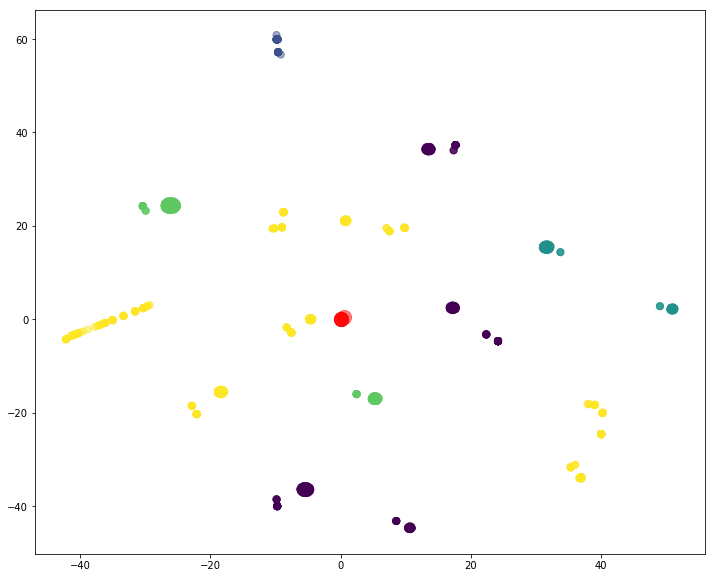

In [28]:
plt.figure(figsize=(12,10))

plt.scatter(tsne[:, 0], tsne[:, 1], c=kmeans_clusters, s=50, cmap='viridis' ,alpha =0.5)
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200,  alpha=0.5)
